## Introduction

### In this notebook, our objective is to find the top 3 Pharmacy locations (in terms of most common venues) near Brooklyn as a neighbourhood


## Download the required Packages 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    li

<a id='item1'></a>

## 1. Download and Explore Dataset - NY data set is available on server

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

## Relevant data is in features key

In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

## Convert into a pandas dataframe as data in form of nested Python Dictionaries

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

## Check columns

In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


## Let's Populate the Dataframe with data

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

## Check dataframe.

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Confirm all 5 boroughs and 306 neighborhoods.

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


## Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## Create a map of New York with neighborhoods shown above it

In [13]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Let's segment and cluster only the neighborhoods in Brooklyn. So let's slice the original dataframe and create a new dataframe of the Brooklyn data.

In [14]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


## Let's get the geographical coordinates of Brooklyn

In [15]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


## Let's visualize Brooklyn and the neighborhoods in it.

In [16]:
# create map of brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

## Lets Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'KCF41DELVEMCIA2KVQ1MJELRS3XPXOYB5WBATHUTZ5TCA0I4' # your Foursquare ID
CLIENT_SECRET = '3USMBE4QZ20XOTX1A0U0YUCJNHTSHESN0DUTGIDF0LPDJHYD' # your Foursquare Secret
VERSION = '20191211' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KCF41DELVEMCIA2KVQ1MJELRS3XPXOYB5WBATHUTZ5TCA0I4
CLIENT_SECRET:3USMBE4QZ20XOTX1A0U0YUCJNHTSHESN0DUTGIDF0LPDJHYD


## Let's explore the first neighborhood in our dataframe and get name.

In [18]:
brooklyn_data.loc[0, 'Neighborhood']

'Bay Ridge'

Get the neighborhood's latitude and longitude values.

In [19]:
neighborhood_latitude = brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bay Ridge are 40.625801065010656, -74.03062069353813.


## Let's get the top 100 venues that are in Bay Ridge within a radius of 500 meters. Get URL.

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=KCF41DELVEMCIA2KVQ1MJELRS3XPXOYB5WBATHUTZ5TCA0I4&client_secret=3USMBE4QZ20XOTX1A0U0YUCJNHTSHESN0DUTGIDF0LPDJHYD&v=20191211&ll=40.625801065010656,-74.03062069353813&radius=500&limit=100'

## Check results with GET

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dce65f5211536001b99036e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Bay Ridge',
  'headerFullLocation': 'Bay Ridge, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 87,
  'suggestedBounds': {'ne': {'lat': 40.63030106951066,
    'lng': -74.02470273356597},
   'sw': {'lat': 40.62130106051065, 'lng': -74.03653865351028}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b895827f964a5206c2d32e3',
       'name': 'Pilo Arts Day Spa and Salon',
       'location': {'address': '8412 3rd Ave',
        'lat': 40.62474788273414,
        'lng': -74.03059056940135,
        'labeledLatLngs': [{'label': 'display',
          'lat':

## We know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Clean the json and structure it into a pandas dataframe.

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()


,name,categories,lat,lng
0,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Bagel Boy,Bagel Shop,40.627896,-74.029335
2,Cocoa Grinder,Juice Bar,40.623967,-74.030863
3,Pegasus Cafe,Breakfast Spot,40.623168,-74.031186
4,Ho' Brah Taco Joint,Taco Place,40.622960,-74.031371


And how many venues were returned by Foursquare?

In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

87 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Brooklyn

#### Let's create a function to repeat the same process to all the neighborhoods in Brooklyn

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Run the above function on each neighborhood and create a new dataframe called brooklyn_venues.

In [26]:

brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


## Check resulting dataframe

In [27]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2820, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


## Venues count for each neighborhood

Matplotlib version:  3.1.1


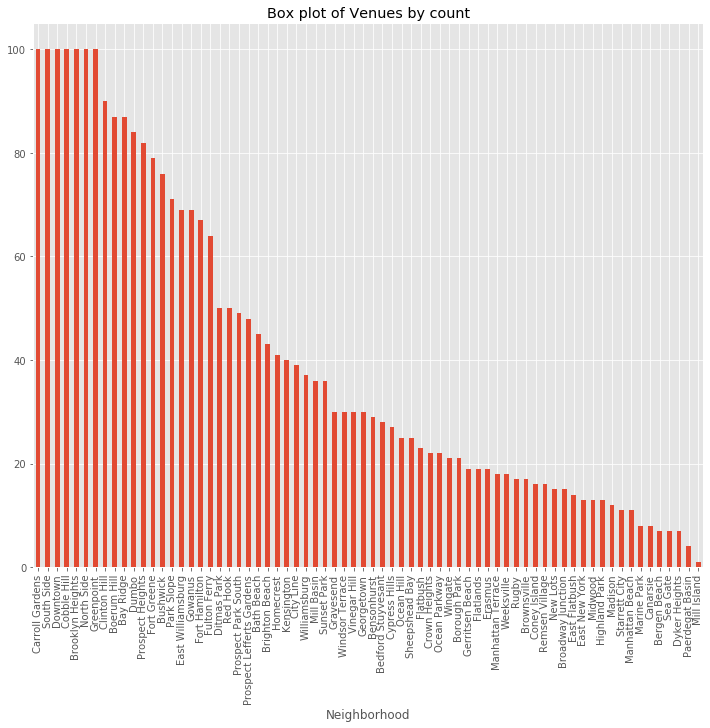

In [28]:
brooklyn_venues.groupby('Neighborhood').count()
Countdf=brooklyn_venues.groupby('Neighborhood').count()
Top_Venues = Countdf.sort_values('Venue', ascending=False)
Top_Venues

Venue_scores = Top_Venues.loc[ : , 'Venue']
Venue_scores
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

#check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
Venue_scores.plot(kind='bar', figsize=(12, 10))

plt.title('Box plot of Venues by count')
plt.ylabel('')

plt.show()


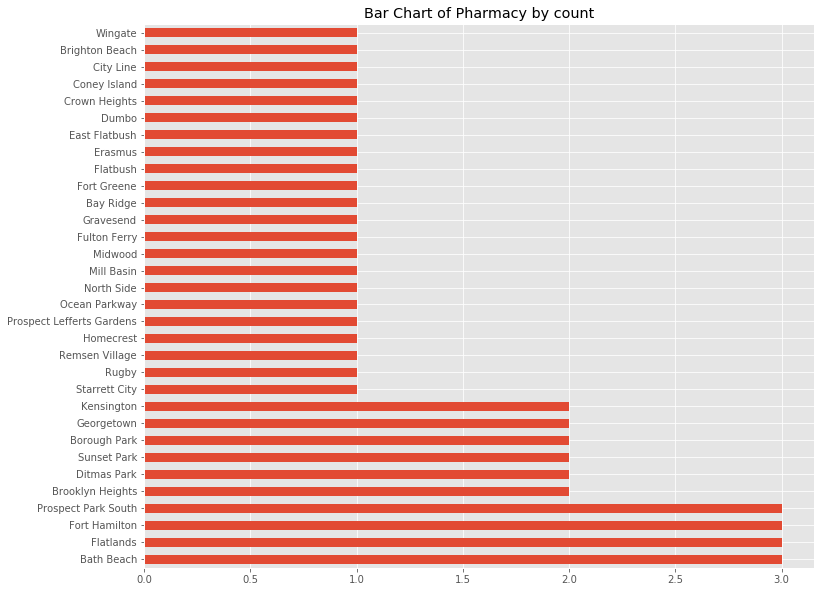

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
54,Bay Ridge,40.625801,-74.030621,Duane Reade,40.622093,-74.027629,Pharmacy
139,Sunset Park,40.645103,-74.010316,Duane Reade,40.645010,-74.010777,Pharmacy
146,Sunset Park,40.645103,-74.010316,Rite Aid,40.643625,-74.012141,Pharmacy
259,Gravesend,40.595260,-73.973471,Rite Aid,40.596756,-73.975457,Pharmacy
295,Brighton Beach,40.576825,-73.965094,Duane Reade,40.576594,-73.967761,Pharmacy
388,Flatbush,40.636326,-73.958401,Rite Aid,40.635575,-73.963514,Pharmacy
407,Crown Heights,40.670829,-73.943291,Rite Aid,40.671123,-73.943461,Pharmacy
415,East Flatbush,40.641718,-73.936103,Rite Aid,40.641799,-73.937224,Pharmacy
461,Kensington,40.642382,-73.980421,Walgreens,40.642677,-73.978856,Pharmacy
463,Kensington,40.642382,-73.980421,Rite Aid,40.643536,-73.977317,Pharmacy


In [29]:
brooklyn_venues.head()
df2 = brooklyn_venues[brooklyn_venues['Venue Category'].str.contains("Pharmacy")]

Countdf2=df2.groupby('Neighborhood').count()
Top_Pharmacy = Countdf2.sort_values('Venue', ascending=False)
Top_Pharmacy
Pharmacy_scores = Top_Pharmacy.loc[ : , 'Venue']
Pharmacy_scores
Pharmacy_scores.plot(kind='barh', figsize=(12, 10))

plt.title('Bar Chart of Pharmacy by count')
plt.ylabel('')

plt.show()
df2
#print(df2[55])

## Unique categories 

In [30]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 287 uniques categories.


<a id='item3'></a>

## 3. Let's Analyze Each Neighborhood seperately

In [31]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Vare

## New dataframe size.

In [32]:
brooklyn_onehot.shape

(2820, 287)

## Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [33]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Vare

## Confirm the new size

In [34]:
brooklyn_grouped.shape

(70, 287)

## Print each neighborhood along with the top 5 most common venues

In [35]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0    Chinese Restaurant  0.07
1              Pharmacy  0.07
2           Pizza Place  0.04
3      Sushi Restaurant  0.04
4  Fast Food Restaurant  0.04


----Bay Ridge----
                venue  freq
0  Italian Restaurant  0.08
1                 Spa  0.07
2         Pizza Place  0.05
3       Grocery Store  0.03
4    Greek Restaurant  0.03


----Bedford Stuyvesant----
           venue  freq
0    Pizza Place  0.07
1  Deli / Bodega  0.07
2            Bar  0.07
3    Coffee Shop  0.07
4           Café  0.07


----Bensonhurst----
                venue  freq
0         Pizza Place  0.10
1  Italian Restaurant  0.07
2  Chinese Restaurant  0.07
3    Sushi Restaurant  0.07
4      Ice Cream Shop  0.07


----Bergen Beach----
                venue  freq
0     Harbor / Marina  0.29
1          Playground  0.14
2   Other Repair Shop  0.14
3  Athletics & Sports  0.14
4          Donut Shop  0.14


----Boerum Hill----
                    venue  freq
0          

## Convert into a pandas dataframe and sort in desc order

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Let's create the new dataframe and display the top 10 venues for each neighborhood.

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pharmacy,Chinese Restaurant,Sushi Restaurant,Bubble Tea Shop,Pizza Place,Donut Shop,Fast Food Restaurant,Kids Store,Italian Restaurant,Cantonese Restaurant
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Bar,Grocery Store,Greek Restaurant,American Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Thai Restaurant
2,Bedford Stuyvesant,Deli / Bodega,Pizza Place,Café,Bar,Coffee Shop,Cocktail Bar,BBQ Joint,Bus Stop,Fried Chicken Joint,Boutique
3,Bensonhurst,Pizza Place,Chinese Restaurant,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Cosmetics Shop,Noodle House,Liquor Store,Factory,Cha Chaan Teng
4,Bergen Beach,Harbor / Marina,Other Repair Shop,Donut Shop,Athletics & Sports,Baseball Field,Playground,Food & Drink Shop,Food,Flower Shop,Fish Market


## Find out which locations have Pharmacy as the most common location 

In [38]:
df1 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains("Pharmacy")] 
df1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pharmacy,Chinese Restaurant,Sushi Restaurant,Bubble Tea Shop,Pizza Place,Donut Shop,Fast Food Restaurant,Kids Store,Italian Restaurant,Cantonese Restaurant
29,Flatlands,Pharmacy,Caribbean Restaurant,Fast Food Restaurant,Deli / Bodega,Fried Chicken Joint,Discount Store,Bar,Video Store,Nightclub,Electronics Store


## Find out which locations have Pharmacy as the 2nd most common location 

In [39]:
df2 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains("Pharmacy")] 
df2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Fort Hamilton,Deli / Bodega,Pharmacy,Chinese Restaurant,Sandwich Place,Bank,Bagel Shop,Diner,Cocktail Bar,Pub,Japanese Restaurant
33,Georgetown,Bank,Pharmacy,Breakfast Spot,Donut Shop,Pizza Place,Shopping Mall,Burger Joint,Shipping Store,Sandwich Place,Clothing Store
56,Prospect Park South,Caribbean Restaurant,Pharmacy,Fast Food Restaurant,Grocery Store,Pizza Place,Donut Shop,Mobile Phone Shop,Latin American Restaurant,Fried Chicken Joint,Mexican Restaurant


## Find out which locations have Pharmacy as the 3rd most common location 

In [40]:
df3 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains("Pharmacy")] 
df3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Ditmas Park,Deli / Bodega,Pizza Place,Pharmacy,Kids Store,Caribbean Restaurant,Chinese Restaurant,Donut Shop,Discount Store,Women's Store,Japanese Restaurant


## Finally - Concluding the Neighborhoods that have Pharmacy as most common Venue

In [42]:
print ("\n""The Neighborhoods of Brooklyn that have Pharmacy as most common Venues among top 3 are:""\n")
print(df1.Neighborhood[0]) 
print(df1.Neighborhood[29])
print(df2.Neighborhood[31])
print(df2.Neighborhood[33])
print(df2.Neighborhood[56])
print(df3.Neighborhood[20])



The Neighborhoods of Brooklyn that have Pharmacy as most common Venues among top 3 are:

Bath Beach
Flatlands
Fort Hamilton
Georgetown
Prospect Park South
Ditmas Park


<a id='item4'></a>

<a id='item5'></a>